In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import hamming_loss
from scipy.sparse import lil_matrix
from tqdm import tqdm
import os

# -----------------------------
# Parameters
# -----------------------------
# k = 10
# m = 240
# e = 20
# n = 2000
# nt = 501
# p = 6000
# d = 2456

d = 983
e = 248 # 3k*logd
k = 12
m = 240
n = 1580
nt = 393
p = 500
GT_type = "sparse_rand"
seed = 42


In [2]:
np.random.seed(seed)


# -----------------------------
# Dataset Loader
# -----------------------------
def load_dataset(path, n_samples, p, d):
    X = lil_matrix((n_samples, p), dtype=np.float32)
    Y = np.zeros((n_samples, d), dtype=np.int32)

    with open(path, 'r') as f:
        # header = f.readline().strip()
        # print("Header:", header)
        for i, line in tqdm(enumerate(f), total=n_samples):
            if i >= n_samples:
                break
            parts = line.strip().split()
            labels = parts[0].split(',')
            for l in labels:
                try:
                    idx = int(l)
                    if 0 <= idx < d:
                        Y[i, idx] = 1
                except ValueError:
                    pass  # skip malformed or non-integer label

            for item in parts[1:]:
                if ':' in item:
                    idx_val = item.split(':')
                    if len(idx_val) != 2:
                        continue
                    try:
                        idx, val = int(idx_val[0]), float(idx_val[1])
                        if 0 <= idx < p:
                            X[i, idx] = val
                    except ValueError:
                        continue

            if i == 0:
                print("Parsed labels:", labels)
                print("First 10 non-zero features:", [(idx, X[i, idx]) for idx in X[i].nonzero()[1][:10]])

    return X.tocsr(), Y


In [3]:

# -----------------------------
# GT Matrix Builder
# -----------------------------
def build_gt_matrix(d, m, method="sparse_rand"):
    A = np.zeros((m, d), dtype=int)
    s = int(np.ceil(np.log2(d)))  # ensure better disjunct properties
    for j in range(d):
        ones = np.random.choice(m, size=s, replace=False)
        A[ones, j] = 1
    return A


# -----------------------------
# MLGT Training (Algorithm 1)
# -----------------------------
from sklearn.linear_model import LogisticRegression

def train_classifiers(X, Y, A):
    Z = np.zeros((X.shape[0], A.shape[0]), dtype=int)
    for i in range(X.shape[0]):
        Z[i] = np.any(A[:, Y[i] == 1], axis=1).astype(int)

    classifiers = []
    for j in tqdm(range(A.shape[0])):
        clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
        clf.fit(X.toarray(), Z[:, j])
        classifiers.append(clf)

    # print training error
    Y_pred = np.zeros((X.shape[0], A.shape[0]), dtype=int)
    for j in range(A.shape[0]):
        Y_pred[:, j] = classifiers[j].predict(X)
    Y_pred = (Y_pred @ A > 0).astype(int)
    print("Training Hamming Loss:", hamming_loss(Y, Y_pred))
    # print training precision
    for k in range(1, 11):
        print(f"Training Precision@{k}:", precision_at_k(Y, Y_pred, k))
    # print training precision at k avg
    print("Training Precision@k avg:", np.mean([precision_at_k(Y, Y_pred, k) for k in range(1, 11)]))
    return classifiers


# -----------------------------
# MLGT Prediction with Probabilities
# -----------------------------
def predict_all_scores(X, classifiers, A):
    m = len(classifiers)
    print("converting to dense in test")
    X_dense = X.toarray()  # Convert once before batch prediction
    X = X_dense
    print("converted to dense in test")

    Z_hat = np.zeros((X.shape[0], m))
    for j, clf in enumerate(classifiers):
        Z_hat[:, j] = clf.predict_proba(X)[:, 1]  # probability of label 1

    Y_scores = np.zeros((X.shape[0], A.shape[1]))
    for l in range(A.shape[1]):
        rows = np.where(A[:, l] == 1)[0]
        Y_scores[:, l] = np.sum(Z_hat[:, rows], axis=1)
    return Y_scores

# -----------------------------
# Thresholding for binary prediction
# -----------------------------
def threshold_predictions(Y_scores, A, e):
    Y_pred = np.zeros_like(Y_scores, dtype=int)
    for l in range(A.shape[1]):
        rows = np.where(A[:, l] == 1)[0]
        for i in range(Y_scores.shape[0]):
            support_misses = np.sum(Y_scores[i, rows] < 0.5)  # count probable 0s
            if support_misses < e / 2:
                Y_pred[i, l] = 1
    return Y_pred

# -----------------------------
# Evaluation
# -----------------------------
def precision_at_k(y_true, y_scores, k):
    precisions = []
    for yt, yp in zip(y_true, y_scores):
        topk = np.argsort(-yp)[:k]
        correct = yt[topk].sum()
        precisions.append(correct / k)
    return np.mean(precisions)


In [4]:

# -----------------------------
# Main
# -----------------------------
dir = 'Delicious/'
file_train = os.path.join(dir, 'train.txt')
file_test  = os.path.join(dir, 'test.txt')

print("Loading training data...")
X_train, Y_train = load_dataset(file_train, n, p, d)
print("Loading test data...")
X_test, Y_test = load_dataset(file_test, nt, p, d)

print("Building GT matrix...")
A = build_gt_matrix(d, m, method=GT_type)

print("Training classifiers...")
classifiers = train_classifiers(X_train, Y_train, A)

print("Predicting test scores...")
Y_scores_gt = predict_all_scores(X_test, classifiers, A)

print("Decoding predictions with thresholding...")
Y_pred_gt = threshold_predictions(Y_scores_gt, A, e)



Loading training data...


100%|██████████| 1580/1580 [00:00<00:00, 25422.75it/s]


Parsed labels: ['77', '91', '315', '544', '575', '621', '718', '818', '819', '834', '908']
First 10 non-zero features: [(np.int32(60), np.float32(1.0)), (np.int32(248), np.float32(1.0)), (np.int32(279), np.float32(1.0)), (np.int32(316), np.float32(1.0)), (np.int32(490), np.float32(1.0))]
Loading test data...


100%|██████████| 393/393 [00:00<00:00, 16521.95it/s]


Parsed labels: ['53', '55', '78', '247', '375', '464', '497', '500', '531', '636', '700', '773', '809', '941', '955', '974']
First 10 non-zero features: [(np.int32(12), np.float32(1.0)), (np.int32(16), np.float32(1.0)), (np.int32(197), np.float32(1.0)), (np.int32(199), np.float32(1.0)), (np.int32(206), np.float32(1.0)), (np.int32(293), np.float32(1.0)), (np.int32(461), np.float32(1.0))]
Building GT matrix...
Training classifiers...


100%|██████████| 240/240 [00:02<00:00, 99.74it/s] 


Training Hamming Loss: 0.9786670873198811
Training Precision@1: 0.017721518987341773
Training Precision@2: 0.03069620253164557
Training Precision@3: 0.022995780590717295
Training Precision@4: 0.022943037974683545
Training Precision@5: 0.019113924050632912
Training Precision@6: 0.016666666666666666
Training Precision@7: 0.015641952983725133
Training Precision@8: 0.015348101265822785
Training Precision@9: 0.022573839662447255
Training Precision@10: 0.02088607594936709
Training Precision@k avg: 0.020458710066305
Predicting test scores...
converting to dense in test
converted to dense in test
Decoding predictions with thresholding...


In [5]:
print("Evaluation")
k_eval = 2
hl = hamming_loss(Y_test, Y_pred_gt)
p2 = precision_at_k(Y_test, Y_scores_gt, k_eval)
print(f"Hamming Loss: {hl:.4f}")
print(f"Precision@{k_eval} : {p2:.4f}")

Evaluation
Hamming Loss: 0.9804
Precision@2 : 0.5344


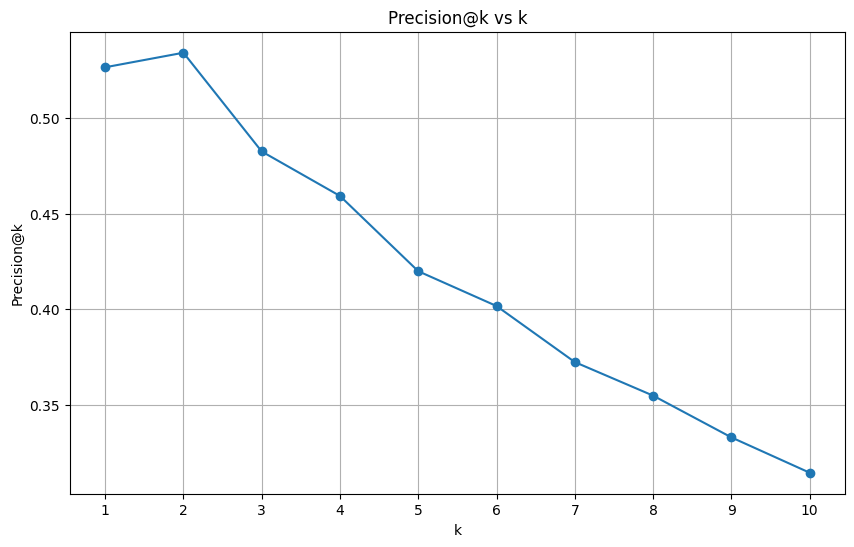

Precision@k avg: 0.3986796735683504


In [6]:
# plot all values from k_eval 1 to 10

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), [precision_at_k(Y_test, Y_scores_gt, k) for k in range(1, 11)], marker='o')
plt.title('Precision@k vs k')
plt.xlabel('k')
plt.ylabel('Precision@k')
plt.xticks(range(1, 11))
plt.grid()
plt.savefig('precision_at_k.png')
plt.show()

# print the precision at k for all k from 1 to k_eval avg
print("Precision@k avg:", np.mean([precision_at_k(Y_test, Y_scores_gt, k) for k in range(1, k + 1)]))

# MLCS

In [7]:
from sklearn.linear_model import Ridge, OrthogonalMatchingPursuit
from sklearn.metrics import hamming_loss
from scipy.linalg import hadamard
from tqdm import tqdm
import numpy as np

# -----------------------------
# CS Matrix Builder
# -----------------------------
def build_cs_matrix(d, m,mode):
    # Random Gaussian matrix scaled to unit variance
    if mode == "Gaussian":
        A = np.random.randn(m, d)
        A /= np.linalg.norm(A, axis=0)
    elif mode == "Hadamard":
        
         # Find smallest power of 2 ≥ d
        d_h = 2 ** int(np.ceil(np.log2(d)))
        H = hadamard(d_h)

        # Subsample m rows uniformly at random
        selected_rows = np.random.choice(d_h, size=m, replace=False)
        A = H[selected_rows, :d]  # Take first d columns if d < d_h

        # Normalize rows to unit norm
        A = A / np.sqrt(d)
    return A

# -----------------------------
# MLCS Training
# -----------------------------
def train_regressors(X, Y, A_cs, alpha=1.0):
    Z = Y @ A_cs.T  # Compressed labels
    regressors = []

    for j in tqdm(range(A_cs.shape[0])):
        reg = Ridge(alpha=alpha)
        reg.fit(X.toarray(), Z[:, j])
        regressors.append(reg)
    
    return regressors

# -----------------------------
# MLCS Prediction + Sparse Recovery
# -----------------------------
def predict_all_scores_cs(X, regressors, A_cs, k):
    X = X.toarray()
    m = len(regressors)

    Z_hat = np.zeros((X.shape[0], m))
    for j, reg in enumerate(regressors):
        Z_hat[:, j] = reg.predict(X)

    Y_scores = np.zeros((X.shape[0], A_cs.shape[1]))
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=k)
    for i in range(X.shape[0]):
        omp.fit(A_cs, Z_hat[i])
        y_hat = omp.coef_
        Y_scores[i] = y_hat

    return Y_scores

# -----------------------------
# Thresholding for MLCS
# -----------------------------
def threshold_predictions_cs(Y_scores, threshold=0.5):
    return (Y_scores >= threshold).astype(int)

# -----------------------------
# Evaluation Reuse
# -----------------------------
def precision_at_k(y_true, y_scores, k):
    precisions = []
    for yt, yp in zip(y_true, y_scores):
        topk = np.argsort(-yp)[:k]
        correct = yt[topk].sum()
        precisions.append(correct / k)
    return np.mean(precisions)


In [8]:

# -----------------------------
# Main
# -----------------------------
dir = 'Delicious/'
file_train = os.path.join(dir, 'train.txt')
file_test  = os.path.join(dir, 'test.txt')

print("Loading training data...")
X_train, Y_train = load_dataset(file_train, n, p, d)
print("Loading test data...")
X_test, Y_test = load_dataset(file_test, nt, p, d)

Loading training data...


100%|██████████| 1580/1580 [00:00<00:00, 30268.15it/s]


Parsed labels: ['77', '91', '315', '544', '575', '621', '718', '818', '819', '834', '908']
First 10 non-zero features: [(np.int32(60), np.float32(1.0)), (np.int32(248), np.float32(1.0)), (np.int32(279), np.float32(1.0)), (np.int32(316), np.float32(1.0)), (np.int32(490), np.float32(1.0))]
Loading test data...


100%|██████████| 393/393 [00:00<00:00, 28510.47it/s]

Parsed labels: ['53', '55', '78', '247', '375', '464', '497', '500', '531', '636', '700', '773', '809', '941', '955', '974']
First 10 non-zero features: [(np.int32(12), np.float32(1.0)), (np.int32(16), np.float32(1.0)), (np.int32(197), np.float32(1.0)), (np.int32(199), np.float32(1.0)), (np.int32(206), np.float32(1.0)), (np.int32(293), np.float32(1.0)), (np.int32(461), np.float32(1.0))]


In [9]:
# MLCS
mode = "Hadamard"
print("Building cs matrix...")
A = build_cs_matrix(d, m, mode)


print("Training regressor...")
classifiers = train_regressors(X_train, Y_train, A)

print("Predicting test scores...")
Y_scores = predict_all_scores_cs(X_test, classifiers, A, k)

print("Decoding predictions with thresholding...")
Y_pred = threshold_predictions_cs(Y_scores, 0.5)


Building cs matrix...
Training regressor...


100%|██████████| 240/240 [00:12<00:00, 18.71it/s]


Predicting test scores...
Decoding predictions with thresholding...


In [10]:
print("Evaluation")
k_eval = 2
hl = hamming_loss(Y_test, Y_pred)
p2 = precision_at_k(Y_test, Y_scores, k_eval)
print(f"Hamming Loss: {hl:.4f}")
print(f"Precision@{k_eval} : {p2:.4f}")

Evaluation
Hamming Loss: 0.0207
Precision@2 : 0.5025


In [13]:
Y_scores_gt.shape

(393, 983)

  0%|          | 0/240 [00:00<?, ?it/s]

100%|██████████| 240/240 [00:11<00:00, 21.48it/s]


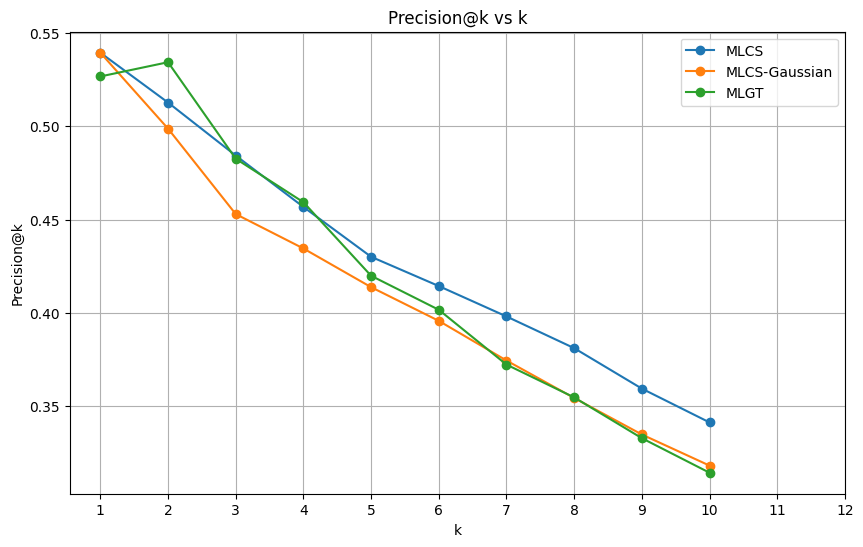

In [14]:
# plot all the values precision at k vs k from 1 to 12 for all methods
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
mode = "Hadamard"
A = build_cs_matrix(d, m, mode)
classifiers = train_regressors(X_train, Y_train, A)
Y_scores = predict_all_scores_cs(X_test, classifiers, A, k)
plt.plot(range(1, 11), [precision_at_k(Y_test, Y_scores, k) for k in range(1, 11)], marker='o', label='MLCS')
mode = "Gaussian"
A = build_cs_matrix(d, m, mode)
classifiers = train_regressors(X_train, Y_train, A)
Y_scores = predict_all_scores_cs(X_test, classifiers, A, k)
plt.plot(range(1, 11), [precision_at_k(Y_test, Y_scores, k) for k in range(1, 11)], marker='o', label='MLCS-Gaussian')

plt.plot(range(1, 11), [precision_at_k(Y_test, Y_scores_gt, k) for k in range(1, 11)], marker='o', label='MLGT')
plt.title('Precision@k vs k')
plt.xlabel('k')
plt.ylabel('Precision@k')
plt.xticks(range(1, 13))
plt.grid()
plt.legend()
plt.savefig('precision_at_k_all.png')
plt.show()